<a href="https://colab.research.google.com/github/monimoreno2905/Parcial1-IA/blob/main/ParcialPunto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. IMPORTAR LIBRERIAS

In [1]:
#Las siguientes dos librerias aseguran que se este usando la versión de python mayor a 3.5
#de lo contrario detendrá la ejecución del programa
import sys
assert sys.version_info >= (3, 5)

# Se verifica que se tenga una versión de sklearn mayor a 0.2.
#La libreria proporciona herramientas para la ejecución de algortimos de clasificación, regresión, etc.
import sklearn
assert sklearn.__version__ >= "0.20"

#Verifica si el entorno en donde se está ejeutando el código es collab
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

#Importa y verifica la versión de tensorflow que es una libreria que sirve para crear modelos de redes neuronales
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#Realiza la detección de GPU
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# en este contexto numpy se utiliza para hacer algunas operaciones matemáticas y definir arreglos
import numpy as np
#En este ejercicio básicamente se utiliza para manipular directorios
import os

from tensorflow.keras import layers

# Con esto se garantiza que produzcan los mismos resultados cada vez que se ejecuta el código
np.random.seed(42)
tf.random.set_seed(42)

# Librerias para la generación de gráficas
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#configurar etiquetas de los ejes, tamaños etc
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Directorio para guardar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

#Esta función se utiliza en el caso de que se requieran guardar los resultados
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    #Ayuda a prevenir sobreposición de elementos de la grafica al guardarla
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


2. FUNCIONES

Aquí se definen algunas funciones que serán de utilidad para gráficas especialmente

In [3]:
#Grafica imágenes originales vs reconstruidas del mnist después de aplicar el modelo encoder, decoder
#Los datos que se le ingresa son: el modelo de reconstrucción, las imágenes originales de las cuales siempre se van a graficar cinco
def show_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images]) #aplica el modelo de autoencoer para sacar imagenes reconstruidas
    fig = plt.figure(figsize=(n_images * 1.5, 3)) #Establece los parámetros de la figura como por ejemplo el tamaño
    for image_index in range(n_images): #En cada iteración, dibuja la imagen original y su reconstrucción correspondiente en la figura.
        plt.subplot(2, n_images, 1 + image_index) #grafica imágenes originales
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index) #grafica reconstrucciones
        plot_image(reconstructions[image_index])

In [5]:
#esta función se utiliza internamente en la función show_reconstructions para graficar las imagenes reconstruidas
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [4]:
#Esta función se utiliza más adelante para generar gráficas sintéticas
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images) #establece el número de filas y columnas que tiene la figura
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1: #comprueba si las imágenes tienen una dimensión de canal extra para eliminarla
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows)) #define la figura
    for index, image in enumerate(images): #Graficar en cada ciclo la respectiva imagen sintética
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [6]:
#Esta función se utiliza para regularizar la activación de una determinada capa de una red neuronal
#utilizando la divergencia de Kullback-Leibler (KL). Este término corresponde al segundo valor de la función
# de costos obtenida en la parte teórcia. Esta divergencia es siempre positiva y teniendo en cuenta que mide
#la distancia entre dos distribuciones de probabilidad es mejor que este valor sea pequeño
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence #se llama el método

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1): # Toma dos parámetros: weight, que es el peso de la regularización, y target, que es el objetivo deseado para las activaciones
        self.weight = weight
        self.target = target
    def __call__(self, inputs): #Toma las activaciones como entrada y calcula la regularización utilizando la divergencia de Kullback-Leibler
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [7]:
#Convierte las probabilidades en un problema de clasificación binaria
#redondea las etiquetas verdaderas y predichas a un valor binario
#esto suele hacerse para realizar una comparación más suave y flexible
#La función se utilizará para compilar los modelos más adelante
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

2. CARGAR LA BASE DE DATOS FASHION-MNIST:
Se carga la base de datos fashion mnist que dispone de imágenes de prendas, dichas imágenes están en escala de grises y tienen un tamaño de 28x28 píxeles. Hay 10 clases diferentes

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255 #normalización de los datos
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:] #Se toman solo algunos datos, no todos
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


3. ENTRENAMIENTO SIN NINGÚN TIP

Se corre el código original de autoencoder aplicado a la base de datos m-nist. Sin aplicar ninguna regularización, dropout, bacth normalization para luego hacer la comparación con los tips de entrenamiento.

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

#Se entrena un encoder con capas densas
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), #se aplanan los datos para pasarlos a las capas densas
    #Capas densas
    keras.layers.Dense(10),
    keras.layers.Dense(20),
    keras.layers.Dense(30),
])
#Se define el decoder
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, input_shape=[30]), #recibe salida del decoder
    keras.layers.Dense(50,  input_shape=[30]), #Capa desna
    keras.layers.Dense(28 * 28),
    keras.layers.Reshape([28, 28]) #imágenes reconstruidas
])

simple_ae = keras.models.Sequential([simple_encoder, simple_decoder]) #concatena el modelo
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.001),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=30, batch_size=8,
                        validation_data=(X_valid, X_valid)) #Se entrena el modelo sobre fashion dataset


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 1.6588 - rounded_accuracy: 0.7197 - val_loss: 1.3383 - val_rounded_accuracy: 0.7777
Epoch 2/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 1.3205 - rounded_accuracy: 0.7795 - val_loss: 1.3246 - val_rounded_accuracy: 0.7785
Epoch 3/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 1.2986 - rounded_accuracy: 0.7740 - val_loss: 1.1886 - val_rounded_accuracy: 0.7709
Epoch 4/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1.1472 - rounded_accuracy: 0.7805 - val_loss: 1.1090 - val_rounded_accuracy: 0.7849
Epoch 5/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1.0803 - rounded_accuracy: 0.7854 - val_loss: 1.0851 - val_rounded_accuracy: 0.7609
Epoch 6/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 2.4933 - rounded_accuracy: 0.7160 - val_loss: 7.8339 - val_rounded_accuracy: 0.4976
Epoch 7/30
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 7.8007 - rounded_accuracy: 0.4996 - val_loss: 7.7778 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


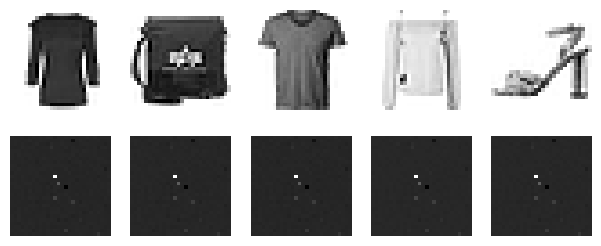

In [10]:
#Se grafican 5 imágenes originales y 5 reconstruidas
show_reconstructions(simple_ae,X_valid)
plt.show()

De los resultados obtenidos tant graficamente como cuantitativamente, se puede observar que el modelo de autoencoder planteado no realiza de manera correcta las reconstrucciones. Respecto al training, por ejemplo, la eficiencia del mismo apenas alcanza el 50% y la perdida es de 7.5 (entre más grande peor la clasificación).

4. TIPS DE ENTRENAMIENTO

Los siguientes tips fueron tomados en cuenta para realizar entrenamiento y validación de los autoencoders sparse, variacionales y gan:

* Uso de inicializadores: Permiten que los pesos del modelo no inicien aleatoriamente para que la información fluya de forma estable en ambas direcciones. Después de varias pruebas se determinó que para los autoencoders y datos evaluados funciona mejor el inicializador "lecun normal". Dicho inicializador escala los pesos de acuerdo con el número de conexiones de entrada. A diferencia de otros inicializadores tiene en cuenta las conexiones de entrada y esto lo que seguramente ayuda a lograr la convergencia.

* Batch normalization: permite realizar un escalamiento de los datos para que sean consistentes entre si.

* Optimizadores: El objetivo del optimizador es encontrar los valores de los parámetros del modelo que minimizan una función de pérdida, la cual mide que tanto se ajustan los datos predichos a los originales. En la mayoria de los casos se utilizó el optimizador Adam con una taza de aprendizaje de 0.1. El optimizador es una versión mejorada del gradiente descendiente y se encarga de ajustar la taza de aprendizaje de acuerdo a cada parámetro del modelo.

* Funciones de activación: son una función matemática que se aplican a la salida de una neurona para establecer relaciones no lineales entre los datos. Entre las funciones más utilizadas en este ejercicio estan: sigmoid a la salida de la redes para generar una probabilidad de pertenencia y versiones mejoradas de relu en capas intermedias con el fin de no acotar las salidas de las neuronas.

* Recorte del gradiente. Esto se hace para que el gradiente no supere cierto umbral evitando con esto que se desvanezca o "explote"

4.1 ENTRENAMIENTO Y EVALUACIÓN DEL AUTOENCODER REGULARIZADO

Un sparse autoencoder incorpora una restricción en la representación latente aprendida por el modelo. Dicha regularización o restricción permite prevenir el sobreajuste ayudando a predecir modelos más robustos y efectivos en datos no vistos.

Algunos métodos son:
* Regularización L1 y L2: agrega términos que son proporcionales a la magnitud de los pesos del modelo. L1 penaliza la magnitud absoluta de los pesos (norma L1), mientras que la regularización L2 penaliza el cuadrado de la magnitud de los pesos (norma L2).

* Regularización de dropout: Durante el entrenamiento, aleatoriamente "apaga" una fracción de las unidades (neuronas) en una capa.

* Regularización por KLDivergence: teniendo en cuenta que mide las distancias entre dos distribuciones de probabilidad, se utiliza para calcular la diferencia entre las activaciones medias de la capa y los objetivos deseados. Cuanto mayor sea la divergencia KL entre estas dos distribuciones, mayor será la penalización aplicada a través de la regularización.

In [ ]:
#Con esto se garantiza que produzcan los mismos resultados cada vez que se ejecuta el código
tf.random.set_seed(42)
np.random.seed(42)

#Se entrena un encoder con capas densas
#respecto a la arquitectura original se hicieron los siguientes cambios:
"""Se cambiaron los inicializadores a lecun normal y la funciones de activación a relu y
Se añadió un regulizador L1"""
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), #se aplanan los datos para pasarlos a las capas densas
    #keras.layers.BatchNormalization(),
    #Capas densas
    keras.layers.Dense(10, activation="relu", kernel_initializer= 'LecunNormal'),
    keras.layers.Dense(20, activation="relu", kernel_initializer= 'LecunNormal'),
    keras.layers.Dense(30, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3) """Regularizador"""
])
#Se define el decoder, con respecto al modelo original no se hizo ningún cambio significativo
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]), #recibe salida del decoder
    keras.layers.Dense(50, activation="selu", input_shape=[30]), #Capa densa
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]) #imágenes reconstruidas
])

simple_ae = keras.models.Sequential([simple_encoder, simple_decoder]) #concatena el modelo
"""compila el modelo con optimizado Adam, aquí se aplica el tip de recortar el gradiente"""
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(lr=1.,clipnorm=1.0),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=50, batch_size=8,
                        validation_data=(X_valid, X_valid)) #Se entrena el modelo sobre fashion dataset, se hizo el cambio de establecer el batch en 8

Epoch 1/50
6875/6875 [==============================] - 40s 5ms/step - loss: 0.3325 - rounded_accuracy: 0.8933 - val_loss: 0.3158 - val_rounded_accuracy: 0.9086
Epoch 2/50
6875/6875 [==============================] - 36s 5ms/step - loss: 0.3111 - rounded_accuracy: 0.9103 - val_loss: 0.3108 - val_rounded_accuracy: 0.9110
Epoch 3/50
6875/6875 [==============================] - 37s 5ms/step - loss: 0.3073 - rounded_accuracy: 0.9127 - val_loss: 0.3087 - val_rounded_accuracy: 0.9125
Epoch 4/50
6875/6875 [==============================] - 32s 5ms/step - loss: 0.3053 - rounded_accuracy: 0.9141 - val_loss: 0.3063 - val_rounded_accuracy: 0.9142
Epoch 5/50
6875/6875 [==============================] - 32s 5ms/step - loss: 0.3040 - rounded_accuracy: 0.9151 - val_loss: 0.3064 - val_rounded_accuracy: 0.9145
Epoch 6/50
6875/6875 [==============================] - 34s 5ms/step - loss: 0.3031 - rounded_accuracy: 0.9157 - val_loss: 0.3045 - val_rounded_accuracy: 0.9154
Epoch 7/50
6875/6875 [============

1/1 [==============================] - 0s 171ms/step


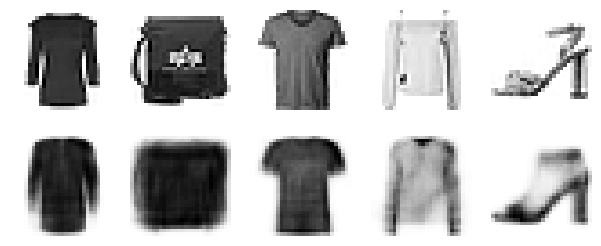

In [ ]:
#Se grafican 5 imágenes originales y 5 reconstruidas
show_reconstructions(simple_ae)
plt.show()

Gráficamente se puede apreciar que los datos reconstruidos son muy similares a los orginales excepto por la cartera, esta tiene un detalle que no se muestra en los datos reconstruidos. Numericamente tanto en training como validation la accuracy llegó hasta aproximadamente el 92.5%, una mejora significativa con respecto al modelo sin tip de entrenamiento y el modelo original que estaba en un accuracy de alrededor del 89%.

Los cambios que permitieron lograr la mejora antes descrita fueron

* Tamaño de batch: que además de reducir el costo computacional, permitió mejorar la convergencia al analizar los datos en grupos de 8.

* Inicializadores y funciones de activación: Los pesos no se iniciaron aleatoriamente y relu funcionó en la mayoria de las capas debido a que al acotar entradas negativas se controló la saturación de las imágenes.

* Regularizador: Se establece una penalización en los pesos para evitar el sobreajuste. L1 funcionó mejor que L2 seguramente debido a que la arquitectura no es tan compleja de analizar.

* Optimizador: se uso adam quien controla la taza de aprendizaje por cada parámetro evitando que el gradiente se desvanezca o explote

Como dato interesante al añadir batch normalization, drop out o DKL divergence, los resultados no mejoraron, podría ser posible que como los datos se normalizaron al inicio no existe diferencia significativa entre ellos y por lo tanto no es necesario normalizar. Tampoco se hace necesario aplicar dropout porque la estrutura de la red es sencilla, además el regularizador hace una función parecida.

Teniendo en cuenta la función matemática obtenida en la parte teórica podría decirse que en general se está logrando una buena maximización del termino de elbo.



In [ ]:
"""Ahora se realizó el entrenamiento del mismo autoencoder anterior pero esta vez usando capas convolucionales"""
tf.random.set_seed(42)
np.random.seed(42)

#se establece la arquitectura de manera secuencial
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    #keras.layers.BatchNormalization(),
    #keras.layers.Dropout(rate=0.2),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="leaky_relu",kernel_initializer= 'LecunNormal'), #se conserva el tamaño original de las imágenes
    keras.layers.MaxPool2D(pool_size=2), #se aplica pooling, esto permite reducir costo computacional
    keras.layers.ActivityRegularization(l2=1e-3), """regularizador l2"""
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="leaky_relu",kernel_initializer= 'LecunNormal'),
    keras.layers.MaxPool2D(pool_size=2),
    #keras.layers.Dropout(rate=0.2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu",kernel_initializer= 'LecunNormal'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.ActivityRegularization(l2=1e-3) #regularizador l2
])
#No se aplicaron cambios significativos, en realidad influyó más en los resultados la modificación del encoder
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="leaky_relu",kernel_initializer= 'LecunNormal',
                                 input_shape=[3, 3, 64]), #primera capa convolucional
    keras.layers.ActivityRegularization(l2=1e-3), #solo se agregó este regularizador
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28]) #imagen reconstruida
])
#compilación del modelo
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(lr=0.1,clipnorm=1.0),
                metrics=[rounded_accuracy])
#entrenamiento del modelo, se probo con un batch 4
history = conv_ae.fit(X_train, X_train, epochs=50,batch_size=4,
                      validation_data=(X_valid, X_valid))

Epoch 1/50
13750/13750 [==============================] - 282s 20ms/step - loss: 0.2801 - rounded_accuracy: 0.9431 - val_loss: 0.2654 - val_rounded_accuracy: 0.9549
Epoch 2/50
13750/13750 [==============================] - 275s 20ms/step - loss: 0.2625 - rounded_accuracy: 0.9564 - val_loss: 0.2619 - val_rounded_accuracy: 0.9586
Epoch 3/50
13750/13750 [==============================] - 252s 18ms/step - loss: 0.2603 - rounded_accuracy: 0.9589 - val_loss: 0.2609 - val_rounded_accuracy: 0.9600
Epoch 4/50
13750/13750 [==============================] - 242s 18ms/step - loss: 0.2593 - rounded_accuracy: 0.9603 - val_loss: 0.2594 - val_rounded_accuracy: 0.9623
Epoch 5/50
13750/13750 [==============================] - 262s 19ms/step - loss: 0.2586 - rounded_accuracy: 0.9612 - val_loss: 0.2595 - val_rounded_accuracy: 0.9618
Epoch 6/50
13750/13750 [==============================] - 266s 19ms/step - loss: 0.2581 - rounded_accuracy: 0.9620 - val_loss: 0.2588 - val_rounded_accuracy: 0.9630
Epoch 7/50

1/1 [==============================] - 0s 234ms/step


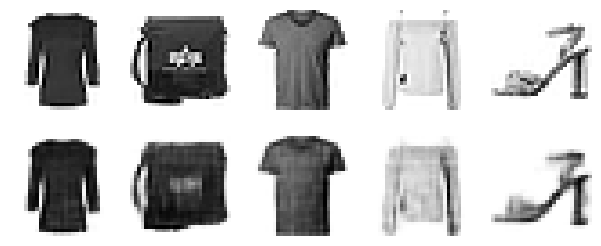

In [ ]:
show_reconstructions(conv_ae)
plt.show()

Con respecto al modelo simple sparse autoencoder el cambió más significativo fue añadir capas convolucionales (más óptimas para analizar imágenes) y funciones de activación leaky relu. Esta función permite no eliminar entradas negativas de los filtros que seguramente porporcionan información relevante para el modelo.

Se puede apreciar que la reconstrucción mejoró y es que el accuracy logrado fue del 97% aproximadamente. Además graficamente, se trató de reconstruir el detalle de la cartera lo que no sucedió en la primera prueba

Con respecto al simple sparse autoencoder otros cambios que permitieron lograr la mejora antes descrita fueron

* Tamaño de batch: 4, la desventaja fue el aumento de costo computacional.

* Regularizador en el decoder


4.2 ENTRENAMIENTO Y EVALUACIÓN VARIACIONAL AUTOENCODER

A diferencia de los anteriores estos modelan la distribución de las variables latentes mediante una distribución de probabilidad. Es decir, son mayormente utilizados en la generación de datos sintéticos ya que toman muestras del espacio latente (ruido por ejemplo)  y tratan de lograr que la distribución de estos datos sea similar a la de los datos originales

En la función de costos también incorporan un termino regularizador DKL divergence, que al medir las distancias entre probabilidades debería tener un valor bajo que no sume mucho a la función de costos

In [ ]:
#Esta función es tipica de los var autoencoder y se encarga de modelar una distribución de
#probabilidad a partir de datos aleatorios como el ruido
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs #media y logaritmo de los datos
        epsilon = tf.random.normal(tf.shape(log_var)) #muestreo de la distribución
        return mean + tf.exp(0.5 * log_var) * epsilon

In [ ]:
#Con la finalidad de realizar comparación sobre los algoritmos anteriores se utilizó este
#autoencoder para reconstruir datos. Además dado que las capas convolucionales funcionaron mejor sobre
#las densas se hizo pruebas únicamente sobre capas convolucionales

#se decidió intentar con 30 épocas porque en las dos pruebas anteriormente hechas se tiende a lograr
#la convergencia a ese nivel

#Para conservar la reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

"""Se procuró parámetros similares a los del sparse autoencoder y por ello se utilizó
leaky relu como función de activación, lecun normal como inicializador, tamaño de kernel=3,
padding same y regularizadores L2"""
codings_size = 10 #Tamaño del vector miu y sigma

#Se trabajó con estructura funcional
#encoder
inputs = keras.layers.Input(shape=[28, 28, 1]) #entrada
z = layers.Conv2D(16, kernel_size=3, padding="SAME", activation="leaky_relu", kernel_initializer='lecun_normal')(inputs)
z=keras.layers.MaxPool2D(pool_size=2)(z) #capa convolucional y posterior su maxpooling
z=keras.layers.ActivityRegularization(l2=1e-3)(z) #regularizador
z = layers.Conv2D(32, kernel_size=3, padding="SAME", activation="leaky_relu", kernel_initializer='lecun_normal')(z)
z=keras.layers.MaxPool2D(pool_size=2)(z) #capa convolucional y posterior su maxpooling
z = layers.Conv2D(64, kernel_size=3, activation="leaky_relu", kernel_initializer='lecun_normal')(z)
z=keras.layers.MaxPool2D(pool_size=2)(z) #capa convolucional y posterior su maxpooling
z=keras.layers.ActivityRegularization(l2=1e-3)(z) #regularizador
z = layers.Flatten()(z) #aplanamiento de los datos
z = keras.layers.Dense(100, activation="leaky_relu",kernel_initializer= 'LecunNormal')(z)
z = keras.layers.Dropout(rate=0.2)(z) #dropout
"""Las siguientes lineas definen la media y la varianza logarítmica de la distribución gaussiana"""
codings_mean = keras.layers.Dense(codings_size)(z) #miu
codings_log_var = keras.layers.Dense(codings_size)(z) #sigma
"""muestreo con ruido"""
codings = Sampling()([codings_mean, codings_log_var]) #Distribución gaussiana
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]) #encoder completo

#Decoder
decoder_inputs = keras.layers.Input(shape=[codings_size]) #recibe la señal del encoder
x = keras.layers.Dense(100, activation="leaky_relu",kernel_initializer= 'LecunNormal')(decoder_inputs)
x = keras.layers.Dense(3*3*64, activation="leaky_relu",kernel_initializer= 'LecunNormal')(x)
x = layers.Reshape((3, 3, 64))(x) #se definen capas densas para hacer el reshape y pasarlo a las capas convolucionales
x=keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="leaky_relu",kernel_initializer= 'LecunNormal',
                                 input_shape=[3, 3, 64])(x)
x=keras.layers.ActivityRegularization(l2=1e-3)(x) #regularizador
x=keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu")(x)
x=keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="selu")(x)
x = layers.Flatten()(x) #Aplanamiento de los datos
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x) #reconstrucción
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

#Construcción del modelo de var autoencoder
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

#Este fragmento de código calcula y agrega la pérdida del término
# de regularización de la distribución latente. El cálculo se hace utilizando
#la fórmula de DKL divergence
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.) #Se normaliza entre el número de píxeles de la imagen
#Compilación del modelo
variational_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(lr=0.1,clipnorm=1.0), metrics=[rounded_accuracy])
#Entrenamiento con un batch size de mayor tamaño para reducir costo computacional
history = variational_ae.fit(X_train, X_train, epochs=30, batch_size=16,
                             validation_data=(X_valid, X_valid))

Epoch 1/30
3438/3438 [==============================] - 327s 94ms/step - loss: 0.3771 - rounded_accuracy: 0.8809 - val_loss: 0.3351 - val_rounded_accuracy: 0.9041
Epoch 2/30
3438/3438 [==============================] - 274s 80ms/step - loss: 0.3297 - rounded_accuracy: 0.9050 - val_loss: 0.3248 - val_rounded_accuracy: 0.9088
Epoch 3/30
3438/3438 [==============================] - 152s 44ms/step - loss: 0.3240 - rounded_accuracy: 0.9085 - val_loss: 0.3224 - val_rounded_accuracy: 0.9125
Epoch 4/30
3438/3438 [==============================] - 160s 47ms/step - loss: 0.3213 - rounded_accuracy: 0.9104 - val_loss: 0.3196 - val_rounded_accuracy: 0.9120
Epoch 5/30
3438/3438 [==============================] - 162s 47ms/step - loss: 0.3198 - rounded_accuracy: 0.9116 - val_loss: 0.3215 - val_rounded_accuracy: 0.9127
Epoch 6/30
3438/3438 [==============================] - 159s 46ms/step - loss: 0.3188 - rounded_accuracy: 0.9123 - val_loss: 0.3173 - val_rounded_accuracy: 0.9144
Epoch 7/30
3438/3438 [

1/1 [==============================] - 0s 346ms/step


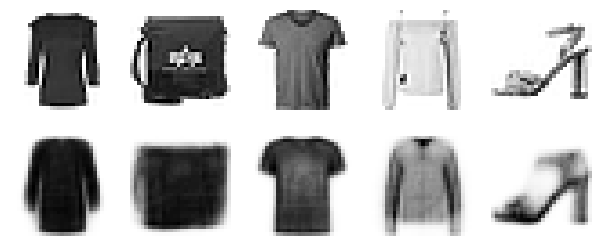

In [ ]:
show_reconstructions(variational_ae)
plt.show()

Gráficamente se puede observar que se obtuvieron resultados muy similares a los del simple sparse autoencoder. La accuracy tendía a mantenerse en 92%, no iba a mejorar significativamente al llegar a 50 épocas.

Comparado con el var autoencoder, la eficiencia no mejoró y esto podria deberse a varios motivos, entre ellos el tamaño del batch que es mayor y la distribución gaussiana que ingresa dentro de la red (podría estarse tomando como ruido). Lo anterior alteraría la convergencia.

4.3 GENERATIVE ADVERSARIAL NETWORK

Son una versión mejorada de los var autoencoder para generar imágenes más realistas. Estas disponen de un generador que genera imágenes sintéticas a partir de datos aleatorios y un discriminador que se encarga de identificar que imágenes son reales y que imágenes son falsas. Estas dos redes se encuentran en competencia tratando de generar imágenes lo más realistas posibles y tratando de diferenciar entre ellas.

In [ ]:
#Esta función es tipica de los gan autoencoder
#El objetivo es entrenar al generador para que cree imágenes lo suficientemente realistas como para engañar al discriminador.
#Necesita el modelo gan, la base de datos en forma de tensor, el batch size
#y codings que definen el tamaño del vector aleatorio y finalmente el número de épocas
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers #obtiene el generador y dicriminador
    for epoch in range(n_epochs): #itera en cada época
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:
            #Se entrena el discriminador
            noise = tf.random.normal(shape=[batch_size, codings_size]) #se genera ruido
            generated_images = generator(noise) #se generan imágenes a partir del ruido
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) #concatena imágenes reales con imágenes generadas
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # se utiliza para crear las etiquetas correspondientes a las imágenes concatenadas en X_fake_and_real
            discriminator.trainable = True #Se utiliza para indicar si los pesos de esa capa deben actualizarse durante el entrenamiento o no
            discriminator.train_on_batch(X_fake_and_real, y1) #se realiza un solo paso de entrenamiento
            # Entrenamiento del generador
            noise = tf.random.normal(shape=[batch_size, codings_size]) #ruido
            y2 = tf.constant([[1.]] * batch_size) #Crear etiquetas
            discriminator.trainable = False #en esta etapa no se entrena el discriminador
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8) #imágenes generadas
        plt.show()

In [ ]:
#en esta prueba solo se entrenó sobre 30 épocas porque en los métodos anteriores la convergencia tendía
#a lograrse en esta etapa
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

#a diferencia de los métodos anteriores se utiliza un regularizador DKL divergence
#que visualmente mejoró los resultados. No se hicieron más cambios significativos
#ya que esta red era muy sensible a cambios y en la primera época se perdia
#toda la información, solo se graficaban puntos en el espacio
kld_reg = KLDivergenceRegularizer(weight=0.005, target=0.01)

#estructura del generador, a diferencia del modelo original en este se añadieron regularizadores
#en las capas densas
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size],activity_regularizer=kld_reg),#regulador con DKL divergence
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(), #se normalizan los datos a diferencia de los métodos anteriores
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"), #el termino stride indica que los filtros se moveran dos pixeles en lugar de uno
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),# al final se aplica solo un filtro y se hace regularización
    keras.layers.ActivityRegularization(l1=1e-3)
])
#Se entrena el discriminador
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4), #se establece un dropout
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

Se observo que al hacer cambios como los descritos más adelante el algoritmo graficaba datos que no se parecian en nada a los originales, solo se graficaban puntos

* tanh por sigmoid: La primera proporciona un rango de salida mas amplio, no acota salidas negativas que seguramente son generadas en el ruido.

* Valor de dropout: cuando se aumentaba este valor con el fin de disminuir el costo computacional, se perdía eficiencia. Seguramente se debe a que se está generando un sobreentrenamiento

* Selú por relu: seguramente como se esta trabajando con funciones de datos aleatorias es necesario no acotar las salidas para evitar eliminar información redundante

* Tamaño de kernel: similar a como paso en dropout al aumentar el tamaño de kernel se disminuia costo computacional pero la convergencia empeoraba

In [ ]:
#Compilación del modelo: al compilar con Adam o SGD los resultados empeoraban
#rmsprop es un método que también ajusta la taza de aprendizaje pero adicionalmente
#normaliza la taza de aprendizaje y tiene una eficiencia mejor computacionalmente

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [ ]:
batch_size = 32 #se genraran 32 imágenes sintéticas
#se convierten las imágenes a tensores
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


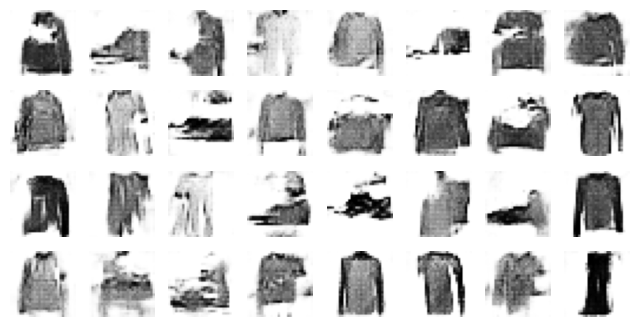

Epoch 2/50


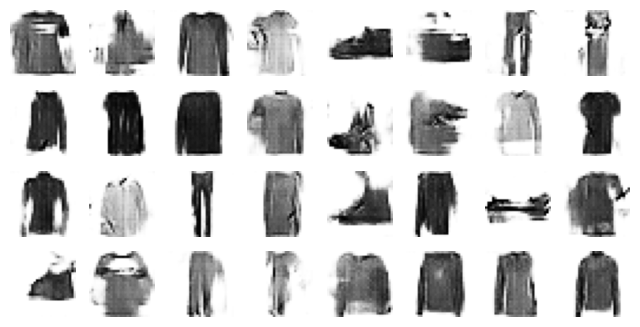

Epoch 3/50


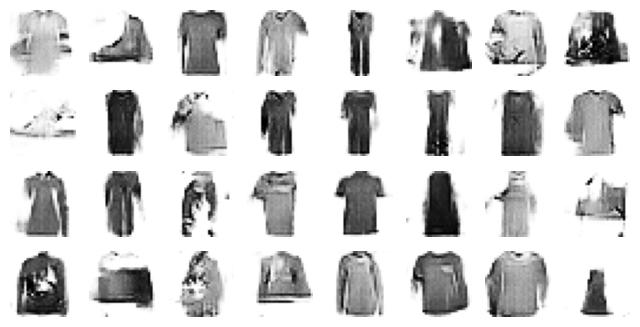

Epoch 4/50


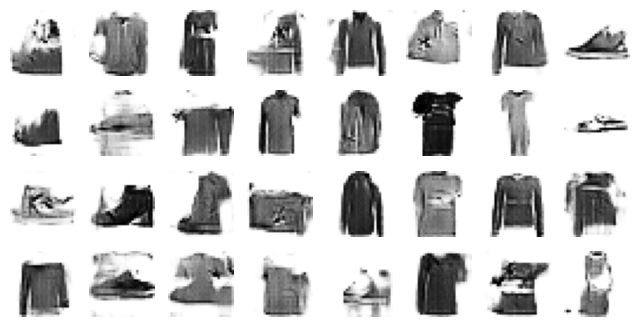

Epoch 5/50


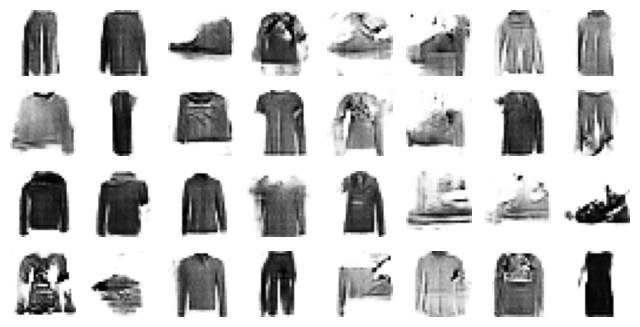

Epoch 6/50


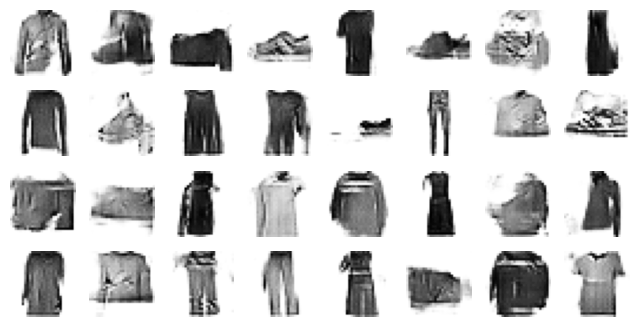

Epoch 7/50


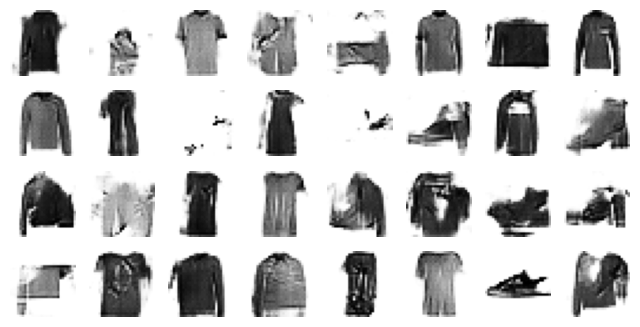

Epoch 8/50


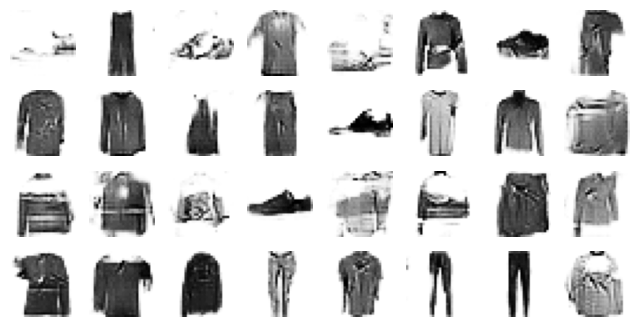

Epoch 9/50


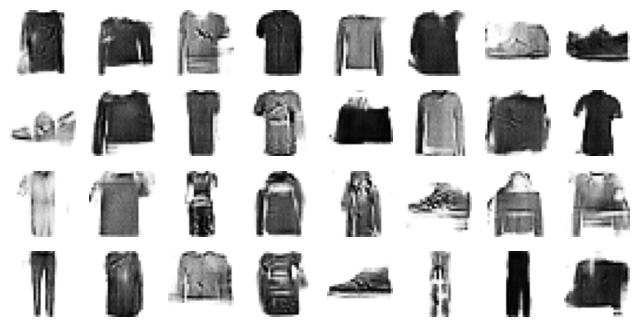

Epoch 10/50


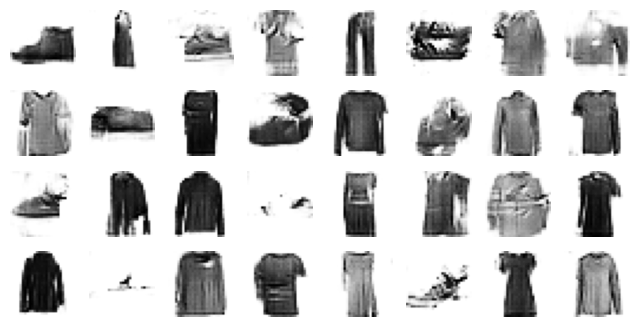

Epoch 11/50


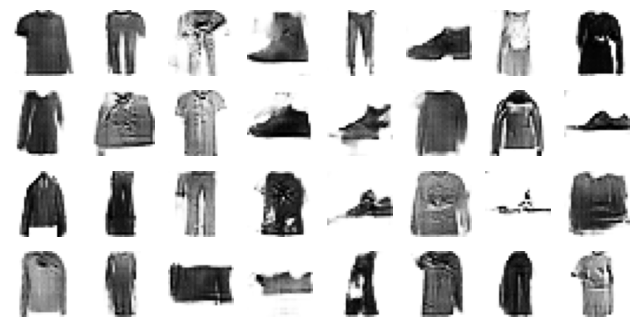

Epoch 12/50


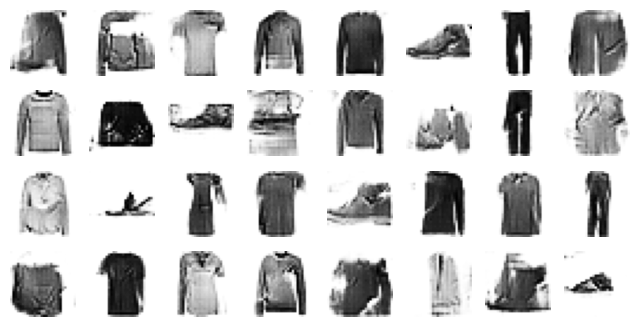

Epoch 13/50


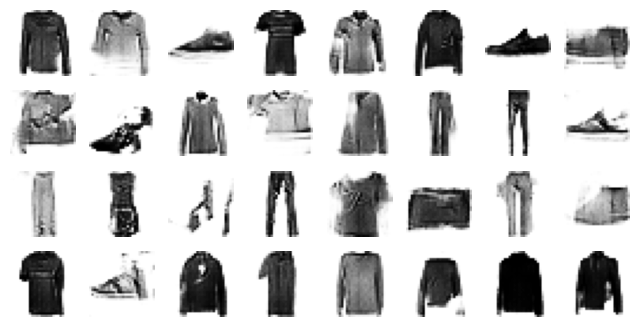

Epoch 14/50


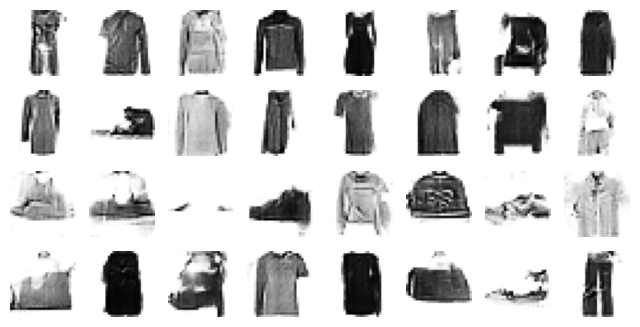

Epoch 15/50


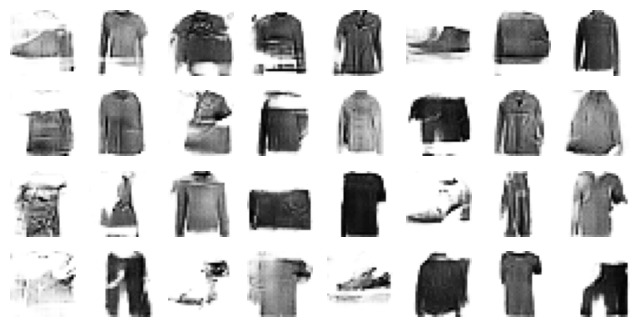

Epoch 16/50


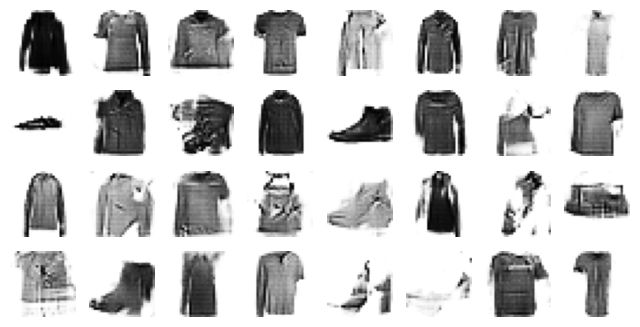

Epoch 17/50


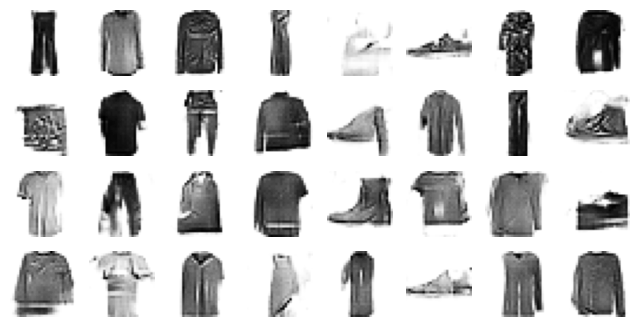

Epoch 18/50


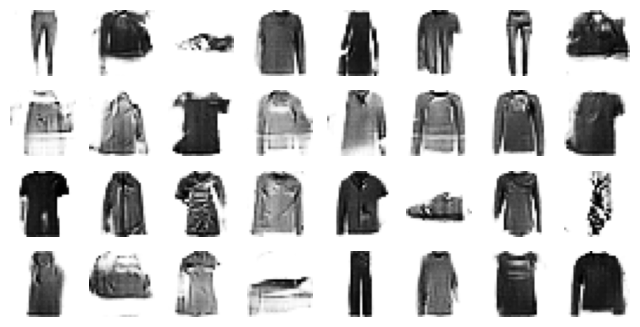

Epoch 19/50


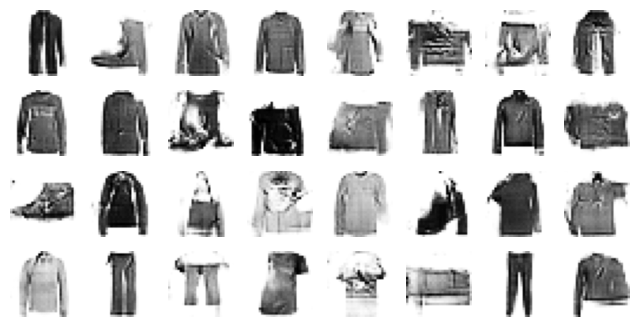

Epoch 20/50


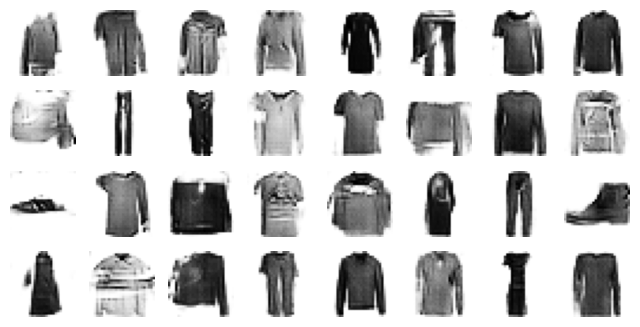

Epoch 21/50


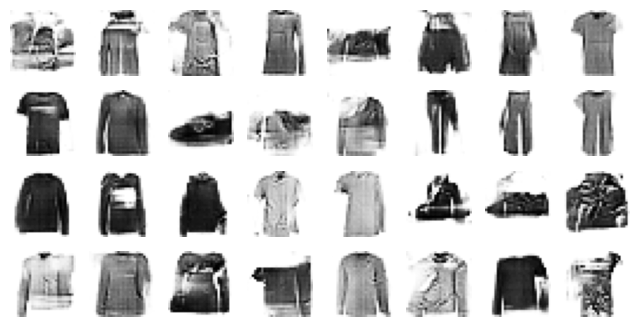

Epoch 22/50


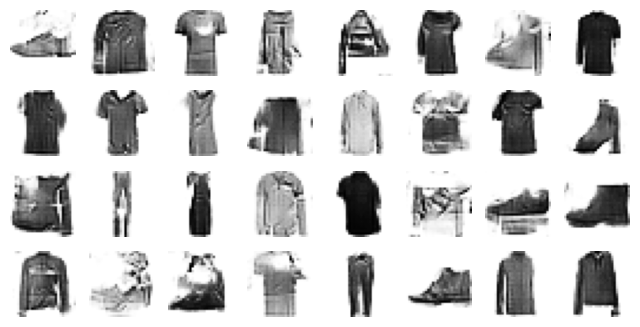

Epoch 23/50


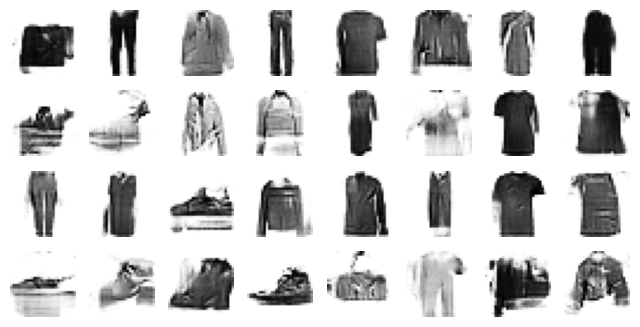

Epoch 24/50


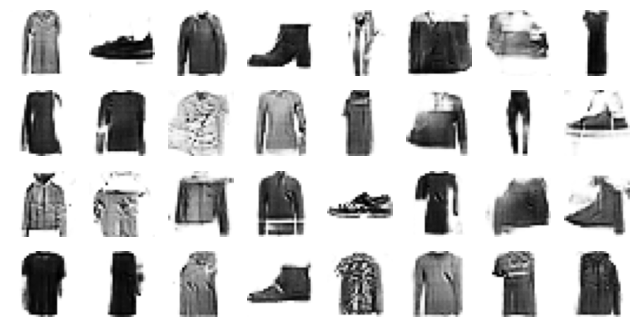

Epoch 25/50


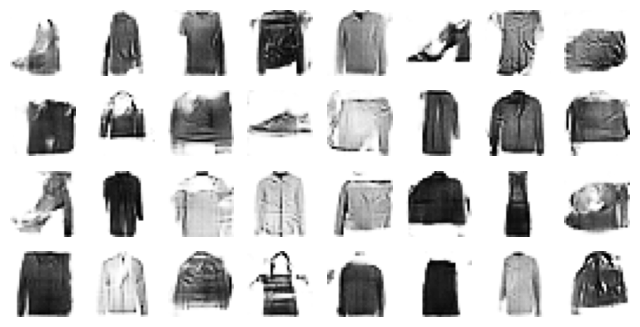

Epoch 26/50


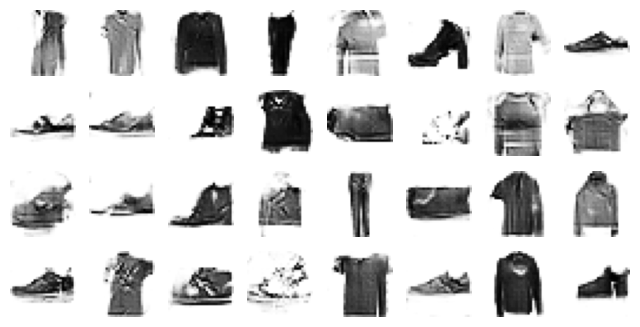

Epoch 27/50


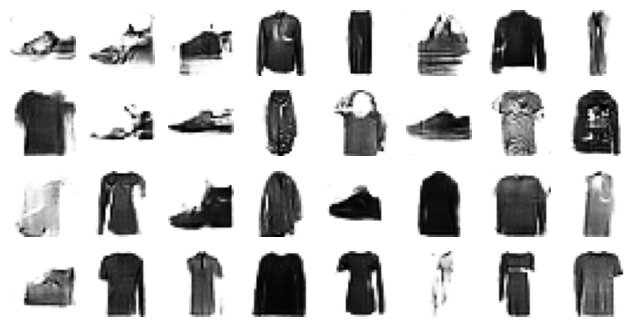

Epoch 28/50


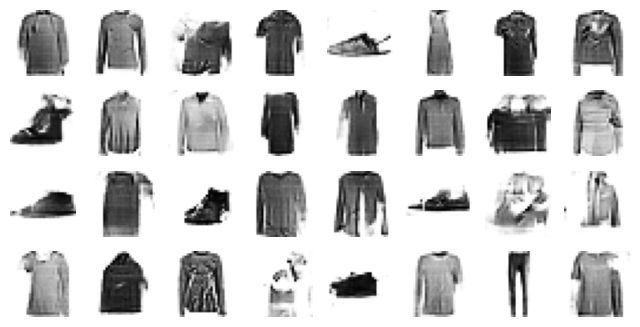

Epoch 29/50


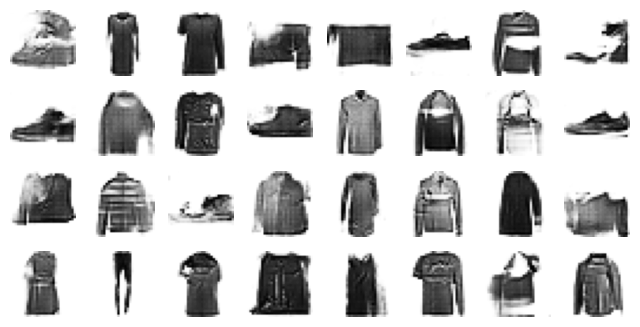

Epoch 30/50


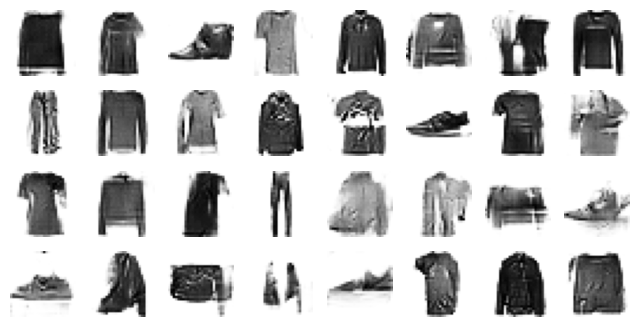

Epoch 31/50


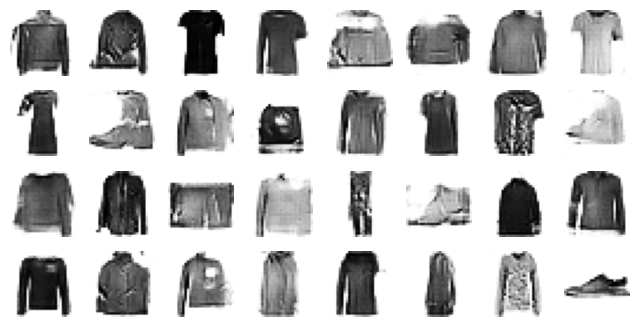

Epoch 32/50


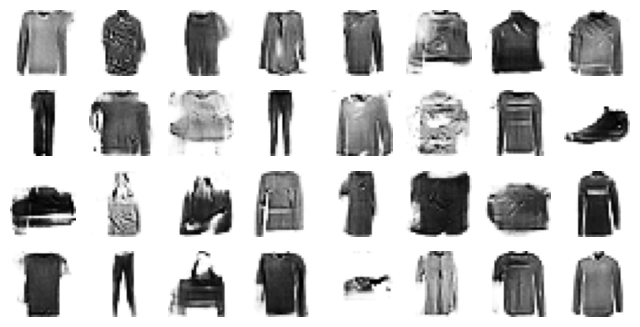

Epoch 33/50


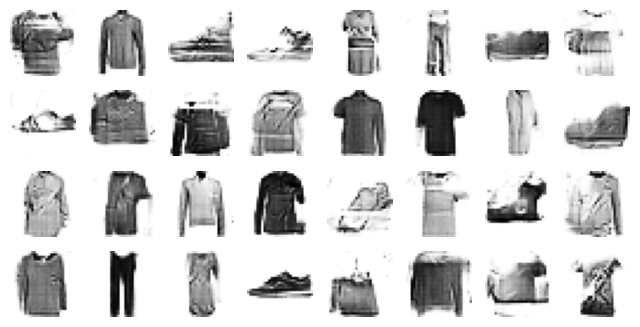

Epoch 34/50


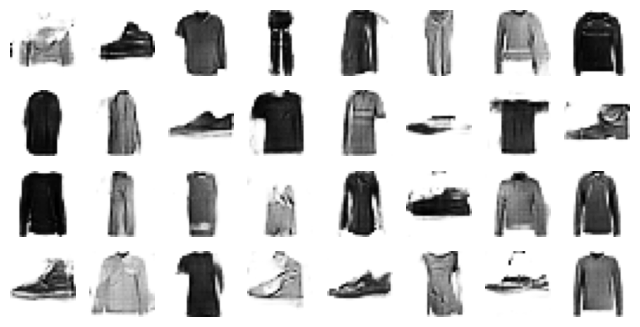

Epoch 35/50


In [ ]:
#se ejecuta la función de entrenamiento del gan
train_gan(gan, dataset, batch_size, codings_size)

Se puede observar que en este último método se puede generar imágenes parecidas a las contenidas en fashion mnist dataset. Las blusas y zapatos son los elementos en los que mejor se distingui la forma de los mismos. Es dificil mirar formas de vestidos, al parecer estos son más dificiles de clasificar ya que en el método de visualización por grad cam++ igualmente resultó más complicado resaltar zonas en esos objetos. Látimosamente, no se pudo hacer converger el código hasta las 50 épocas por asuntos de costo computacional pero teniendo en cuenta la covergencia de los métodos anteriores, podría decirse que esta no tiende a cambiar significativamente